# Kernel Methods

The goal of this class is to implement the _Kernel Trick_ in two applications:
* Kernel Ridge Regression
* Kernel PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Kernels

In [49]:
def gaussian_kernel(x, y, tau=1):
    return np.exp(-np.linalg.norm(x-y)**2/(2*tau**2))

def polynomial_kernel(x, y, p=2):
    return (np.dot(x,y) + 1)**p

In [28]:
n, p = 10, 5
X = np.random.randn(n, p)

K = np.array([gaussian_kernel(X[i], X[j], tau=0.000001) for i in range(n) for j in range(n)]).reshape(n,n)
print('Eigenvalues of the Gaussian Kernel =', np.linalg.eigh(K)[0])

Eigenvalues of the Gaussian Kernel = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [29]:
K = np.array([polynomial_kernel(X[i], X[j], p=2.) for i in range(n) for j in range(n)]).reshape(n,n)
print('Eigenvalues of the Polynomial Kernel =', np.linalg.eigh(K)[0])

Eigenvalues of the Polynomial Kernel = [  0.78016236   1.35900569   3.35372886   5.31736191   7.96778731
  11.93359931  19.26059823  31.44326515  73.95389971 205.02017414]


## Kernel Ridge Regression

We consider some data $x_1, \ldots, x_n \in \mathbb{R}$, with corresponding observations $y_1, \ldots, y_n \in \mathbb{R}$. Our goal is to regress the observations $y$ on the data $X = [x_1, \ldots, x_n]^T \in \mathbb{R}^{n \times 1}$.

In this experiment, we consider noisy and non-linear observations $y_i$ from the model:
$$ y_i = \sin(x_i) + \sigma \xi_i $$
where $\sigma > 0$ is the noise level and $\xi_i \sim \mathcal{N}(0,1)$ are i.i.d.

We will first use a classical Ridge Regression, and then a Kernel Ridge Regression. In the classical Ridge Regression, the goal is to find a parameter $\theta \in \mathbb{R}$ that minimizes the loss
$$ \|y - X\theta\|^2 + \rho \|\theta\|^2 $$

The solution is
$$ \hat\theta = \left(X^T X + \rho \text{Id} \right)^{-1} X^T y $$

This only depends on the scalar products between the data points. If we replace the dot product by a p.d. kernel, we obtain the Kernel Ridge Regressor.

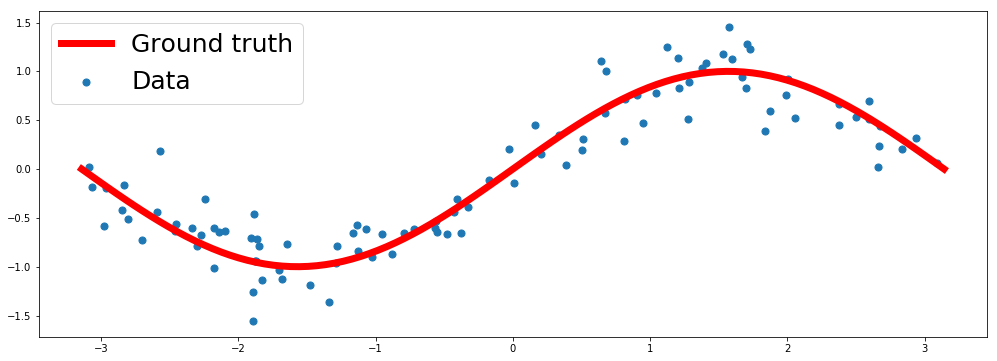

In [44]:
# Define the data
n = 100
rho = 1 # Ridge regression parameter

X = np.random.uniform(low=-np.pi, high=np.pi, size=n)

sigma = 0.2
xi = np.random.randn(n)

y = np.sin(X) + sigma*xi

# Plot the data
plt.figure(figsize=(17,6))
plt.scatter(X, y, s=50, label='Data')
lin = np.linspace(-np.pi, np.pi, 100)
plt.plot(lin, np.sin(lin), c='r', lw=7, label='Ground truth')
plt.legend(loc='best', fontsize=25)
plt.show()

### Ridge Regression

In [45]:
# Learn a Ridge regressor
# We need to add a constant term to the data to fit the intercept
X_ = np.array([X, np.ones(n)]).T
w = np.linalg.inv(X_.T.dot(X_) + rho*np.identity(2)).dot(X_.T).dot(y)

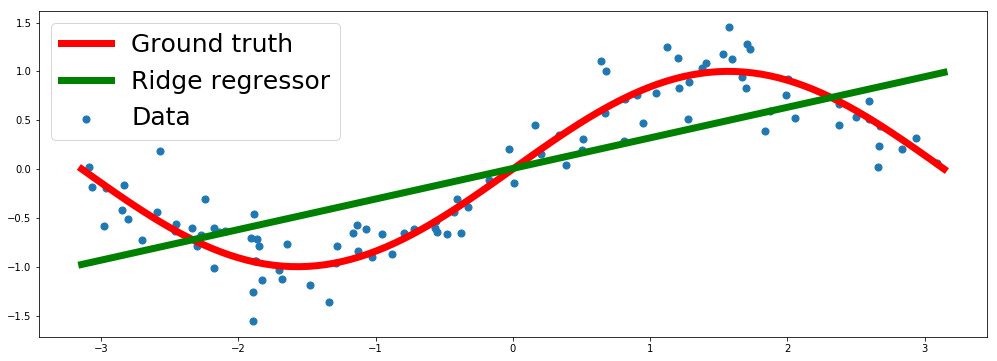

In [46]:
# Plot the predictions
plt.figure(figsize=(17,6))
plt.scatter(X, y, s=50, label='Data')
lin = np.linspace(-np.pi, np.pi, 100)
plt.plot(lin, np.sin(lin), c='r', lw=7, label='Ground truth')
plt.plot(lin, w[1]+w[0]*lin, c='g', lw=7, label='Ridge regressor')
plt.legend(loc='best', fontsize=25)
plt.show()

### Kernel Ridge Regression

We will use the Gaussian Kernel:
$$ k_\tau(x,y) = \exp\left( -\frac{\|x-y\|^2}{2\tau^2} \right) $$

In [47]:
def kernel(x, y, tau=1):
    return np.exp(-np.linalg.norm(x-y)**2/(2*tau**2))

In [58]:
# Compute the Ridge Regressor
K = np.array([polynomial_kernel(X[i], X[j], p=15) for i in range(n) for j in range(n)]).reshape(n,n)
w = np.linalg.inv(K + rho*np.identity(n)).dot(y)

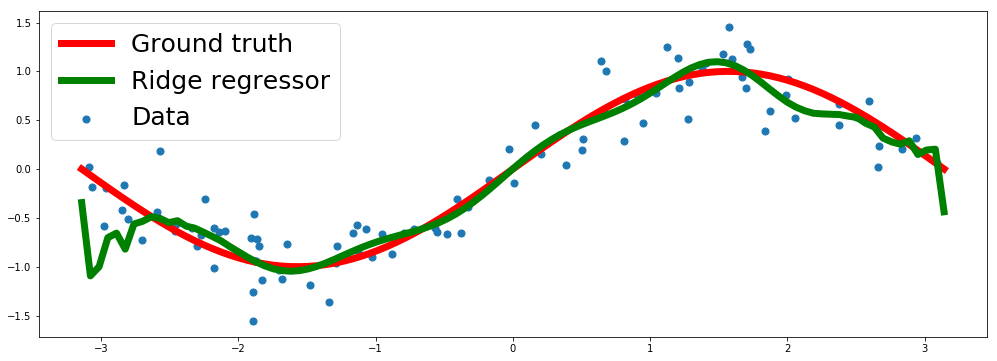

In [59]:
# Plot the preditions
plt.figure(figsize=(17,6))
plt.scatter(X, y, s=50, label='Data')
lin = np.linspace(-np.pi, np.pi, 100)
plt.plot(lin, np.sin(lin), c='r', lw=7, label='Ground truth')
plt.plot(lin, [w.dot(np.array([polynomial_kernel(t, X[i], p=15) for i in range(n)])) for t in lin], c='g', lw=7, label='Ridge regressor')
plt.legend(loc='best', fontsize=25)
plt.show()

## Kernel PCA

We consider $n$ data points dimension $p$: $X \in \mathbb{R}^{n \times p}$. We wish to reduce the dimension of our data, from $p$ to $s << p$.

The goal of the PCA is to find the $s$-dimensional subspace $E$ that "best" fit the data, i.e. that minimizes the loss:
$$ \frac{1}{n} \sum_{i=1}^n \|x_i - \Pi_E(x_i)\|^2 $$
where $\Pi_E$ is the orthogonal projector onto $E$.

Using the Pythagorean theorem, this is equivalent to find a $s$-dimensional subspace $E$ that maximizes the quantity:
$$ \frac{1}{n} \sum_{i=1}^n \|\Pi_E(x_i)\|^2 = \text{Trace}\left(\Pi_E \left[\frac{1}{n} \sum_{i=1}^n x_i x_i^T\right] \Pi_E \right)$$

This quantity is maximized when $E$ is spanned by the top $s$ eigenvectors (i.e. the $s$ eigenvectors associated with the largest $s$ eigenvalues) of the variance matrix $\Sigma = \frac{1}{n} \sum_{i=1}^n x_i x_i^T$.

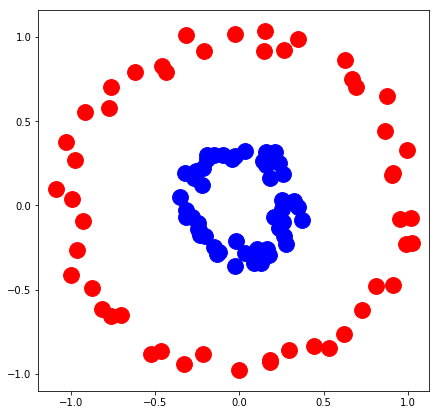

In [61]:
# We consider 2-dimensional data with two classes (red and blue)
# Out goal will be to project this data on a 1-dimensional subspace
# and still be able to cluster the data correctly
from sklearn.datasets import make_circles

n = 100

X, y = make_circles(n_samples=n, factor=.3, noise=.05)

plt.figure(figsize=(7,7))
plt.scatter(X[y==0, 0], X[y==0, 1], c="red", s=250)
plt.scatter(X[y==1, 0], X[y==1, 1], c="blue", s=250)
plt.axis('equal')
plt.show()

### Linear PCA

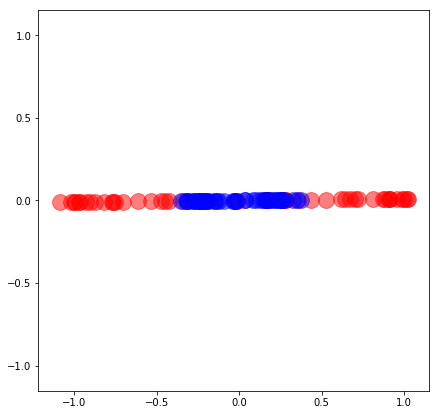

In [71]:
Sigma = (1/n)*X.T.dot(X)
components = np.linalg.eigh(Sigma)[1][:,-1].reshape(2,1)
projected_X = X.dot(components).dot(components.T)

plt.figure(figsize=(7,7))
plt.scatter(projected_X[y==0, 0], projected_X[y==0, 1], c="red", s=250, alpha=0.5)
plt.scatter(projected_X[y==1, 0], projected_X[y==1, 1], c="blue", s=250, alpha=0.5)
plt.axis('equal')
plt.show()

Clearly, PCA does not allow us to separate the data, because the dimensionality reduction is linear. We will use the Kernel Trick to alleviate this problem.

### Kernel PCA

Each datum $x_i$ is now sent to a Hilbert Space $\mathcal{H}$ through a non-linear map $\phi: \mathbb{R}^p \to \mathcal{H}$. We then compute the linear PCA in this space $\mathcal{H}$.

We have to eigendecompose the operator $\Sigma = \frac{1}{n} \sum_{i=1}^n \phi(x_i) \phi(x_i)^T$, where $\phi(x_i) \phi(x_i)^T$ should be thought as the operator $x \to \phi(x_i) \langle \phi(x_i), x \rangle_\mathcal{H}$.

Note that eigenvectors of $\Sigma$ are necessarily elements of $\text{Span}\left( \phi(x_1), \ldots, \phi(x_n) \right)$. This means that, for an eigenvector $v$ with corresponding eigenvalue $\lambda$:
* there exist coefficients $\alpha_1, \ldots \alpha_n$ such that $v = \sum_{i=1}^n \alpha_i \phi(x_i)$,
* the eigenvector $v$ is characterized by the equations $\langle \phi(x_k) , \Sigma v \rangle_\mathcal{H} = \lambda \langle \phi(x_k) , v \rangle_\mathcal{H}$ for all $k=1,\ldots,n$.

Combining those two results gives:
$$ K^2 \alpha = n \lambda K \alpha $$
where $K \in \mathbb{R}^{n \times n}$ is the Kernel matrix, and then $K \alpha = n \lambda \alpha$. In other words, the coefficients vector $\alpha$ is an eigenvector of the Kernel matrix $K$.

In PCA, we ask that the eigenvectors have norm equal to $1$. Here, it means that $\|v\| = 1$, which translates into $\|\alpha\| = \frac{1}{\sqrt{\lambda}}$.

Finally, we also ask that the initial data are centered. We have to ensure that $\sum_{i=1}^n \phi(x_i) = 0_\mathcal{H}$. Centering the data in $\mathcal{H}$ can be shown to be equivalent to using a Kernel matrix $\tilde K = K - 1 K - K 1 + 1 K 1$, where $1 \in \mathbb{R}^{n \times n}$ is the matrix with coefficients $1/n$.

In order to compute the projection of a point $x \in \mathbb{R}^p$ onto the first principal component, we need to compute:
$$ \langle v , \phi(x) \rangle_\mathcal{H} = \sum_{i=1}^n \alpha_i k(x_i, x)$$

In [72]:
def kernel(x, y, tau=0.5):
    return np.exp(-np.linalg.norm(x-y)**2/(tau**2))

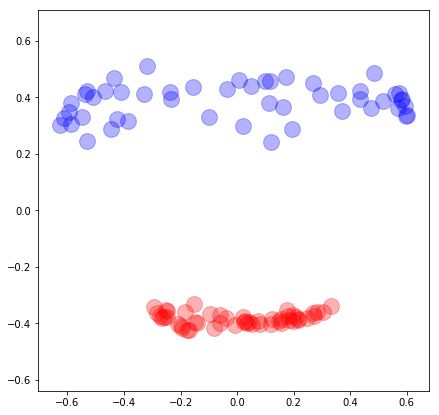

In [79]:
K = np.array([kernel(X[i], X[j]) for i in range(n) for j in range(n)]).reshape(n,n)
ones = (1./n)*np.ones((n,n))
K = K - ones.dot(K) - K.dot(ones) + ones.dot(K).dot(ones)

eigenvalues, eigenvectors = np.linalg.eigh(K)
alpha = eigenvectors[:,-2:]/np.sqrt(eigenvalues[-2:])
projected_points = alpha.T.dot(K)

plt.figure(figsize=(7,7))
plt.scatter(projected_points[0][y==0], projected_points[1][y==0], c='red', s=250, alpha=0.3)
plt.scatter(projected_points[0][y==1], projected_points[1][y==1], c='blue', s=250, alpha=0.3)
plt.axis('equal')
plt.show()

Kernel PCA separates the data using only one dimension.